# Setup

In [8]:
import os

import pandas as pd
import numpy as np

import seaborn as sns

from styles import *
from names import *

from sigfig import round

In [9]:
base = 'data/metrics'
compare_base = ['1xP', '1.5xP', '2xP', '5xP', '10xP']
compare_self = ['1xS', '1.5xS', '2xS', '5xS', '10xS']

compare_base = [pd.read_pickle(os.path.join(base, f'{c}.pkl')) for c in compare_base]
compare_self = [pd.read_pickle(os.path.join(base, f'{c}.pkl')) for c in compare_self]

# Self -> compared with unfiltered images
# Base -> compared with filtered images

In [10]:
base_data = pd.concat(compare_base)
self_data = pd.concat(compare_self)

both = pd.concat([base_data, self_data])

In [11]:
self_data[(self_data['filter'] == 'Baseline') & (self_data['threshold'] == 0.336)]

both['Filter'] = both['filter']
both['Method'] = both['name'].apply(filter_name_map.get)
#both['EER'] = both['eer'].astype(np.float32)
both['Type'] = both['scale'].apply(lambda e: 'E' if e[-1] == 'P' else 'I')
both['Scale'] = both['scale'].apply(lambda e: float(e[:-2]))

In [12]:
both.groupby(['Type', 'Filter', 'Scale'])['threshold']

In [14]:
included = [
    'Bilateral filter',
    'Gaussian filter',
    'Non-local means',
    'Cauchy noise',
    'Snow noise',
    'Comb',
]
self_min = self_data[self_data['filter'].isin(included)]
base_min = base_data[base_data['filter'].isin(included)]

In [23]:
base_min['Scale'] = base_min['scale'].apply(lambda r: r[:-1])
self_min['Scale'] = self_min['scale'].apply(lambda r: r[:-1])

/Users/Anton/anaconda3/envs/iaml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Anton/anaconda3/envs/iaml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Plots

## Precision/recall plot

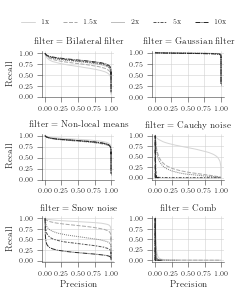

In [24]:

grid = sns.FacetGrid(
    base_min, 
    col='filter', 
    #hue='scale', 
    #palette=sns.color_palette("gray_r", 5),
    col_wrap=2, 
    aspect=1.4, 
    sharex=False,
    sharey=False,
    height=gen_grid('article-col', aspect=1.4, col_wrap=2))
#grid = gen_grid(self_data, 'filter', 'scale', 4)

grid.map_dataframe(sns.lineplot, 
                   x='precision', 
                   y='recall', 
                   hue='Scale', 
                   palette=sns.color_palette("gray_r", 5),
                   style='Scale')#.set(yscale = 'log', xscale='log')

grid.axes_dict['Bilateral filter'].set_ylabel('Recall')
grid.axes_dict['Non-local means'].set_ylabel('Recall')
grid.axes_dict['Snow noise'].set_ylabel('Recall')
grid.axes_dict['Snow noise'].set_xlabel('Precision')
grid.axes_dict['Comb'].set_xlabel('Precision')

for a in grid.axes:
    a.set_xticks(np.linspace(0, 1, 5))
    a.set_yticks(np.linspace(0, 1, 5))
    a.xaxis.grid(True, which='minor')
    a.yaxis.grid(True, which='minor')
    
#plt.legend()
grid.add_legend(loc='upper center', bbox_to_anchor=(0.275, 1.1), ncol=5)

#grid.fig.text(0.5, 0.0, 'precision')

grid.savefig('out/pr_internal.pdf', bbox_inches='tight')

## F1 grid

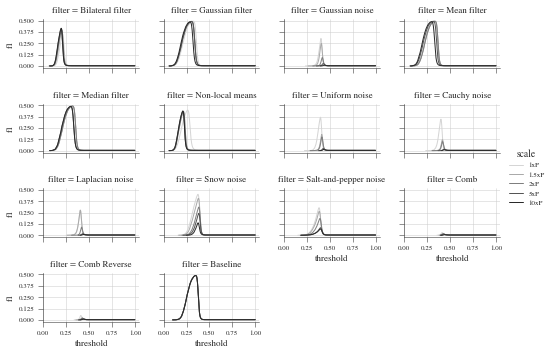

In [5]:
grid = sns.FacetGrid(
    base_data, 
    col='filter', 
    hue='scale', 
    col_wrap=4, 
    palette=sns.color_palette("gray_r", 5),
    #hue_order=['10xS', '5xS', '2xS', '1.5xS', '1xS'],
    aspect=1.4, 
    height=gen_grid('article-full', aspect=1.4, col_wrap=4),
    margin_titles=False)
#grid = gen_grid(self_data, 'filter', 'scale', 4)


grid.map(sns.lineplot, 'threshold', 'f1')#.set(yscale = 'log', xscale='log')

for a in grid.axes:
    a.set_xticks(np.linspace(0, 1, 5))
    a.set_yticks(np.linspace(0, 0.5, 5))
    a.xaxis.grid(True, which='minor')
    a.yaxis.grid(True, which='minor')
grid.add_legend()

grid.savefig('out/g.pdf', bbox_inches='tight')

# Tables

## F1 at threshold table

In [13]:
ts = both[both['threshold'] == 0.336]
ts = ts[ts['Type'] == 'I']
ts = ts[['Filter', 'Type', 'Scale', 'f1']]
ts = ts.pivot(columns='Scale', index=['Type', 'Filter'])
ts = ts.reset_index(0)
ts = ts.drop(columns='Type')
ts

/Users/Anton/anaconda3/envs/iaml/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


f1                                        
Scale                      1.0       1.5       2.0       5.0       10.0
Filter                                                                 
Baseline               0.482803  0.482803  0.482803  0.482803  0.482803
Bilateral filter       0.229830  0.153648  0.143212  0.115634  0.114770
Cauchy noise           0.228304  0.020292  0.010360  0.000280  0.000112
Comb                   0.000727       NaN       NaN       NaN       NaN
Comb Reverse           0.002735  0.000727  0.000392  0.000056       NaN
Gaussian filter        0.489848  0.486837  0.486837  0.486837  0.475755
Gaussian noise         0.155606  0.094072  0.007996  0.000951       NaN
Laplacian noise        0.131297  0.125642  0.006175  0.000448       NaN
Mean filter            0.488736  0.488736  0.488736  0.489421  0.482627
Median filter          0.488987  0.488987  0.488987  0.482413  0.482413
Non-local means        0.422958  0.166057  0.154607  0.118785  0.118785
Salt-and-pepper noise  0.310365  0.276995  0.215208  0.136546  0.116125
Snow noise             0.427803  0.380518  0.275999  0.205444  0.104646
Uniform noise          0.254673  0.041374  0.026060  0.000783  0.000112

In [7]:
ts.to_latex(
    'out/direct-attack.tex',
    multicolumn=True, 
    multirow=True, 
    decimal='.', 
    index=True, 
    longtable=False,
    escape=False,
    float_format=lambda x: '{:0.2f}'.format(x),
    na_rep='NA')

In [14]:
pd.options.mode.chained_assignment = None

## Max F1 table

In [12]:
both['Type'] = both['scale'].apply(lambda e: 'External' if e[-1] == 'P' else 'Internal')
both['Scale'] = both['scale'].apply(lambda e: float(e[:-2]))

In [13]:
gg = both.groupby(['filter', 'Type', 'Scale']).agg({'f1': 'max'})
gg = gg.reset_index()
gg = gg.pivot(columns=['Type', 'Scale'], index=['filter'])

In [14]:
gg

f1                                          \
Type                   External                                           
Scale                      1.0       1.5       2.0       5.0       10.0   
filter                                                                    
Baseline               0.487978  0.487978  0.487978  0.487978  0.487978   
Bilateral filter       0.351786  0.379622  0.399095  0.406765  0.414385   
Cauchy noise           0.345677  0.120243  0.099752  0.015005  0.009037   
Comb                   0.029939  0.018310  0.017309  0.011527  0.006455   
Comb Reverse           0.048627  0.022360  0.019903  0.013144  0.007929   
Gaussian filter        0.492453  0.489977  0.489977  0.489977  0.485589   
Gaussian noise         0.302653  0.248257  0.092464  0.025913  0.008676   
Laplacian noise        0.276901  0.274686  0.088887  0.016952  0.008590   
Mean filter            0.491968  0.491968  0.491968  0.491908  0.487553   
Median filter          0.491193  0.491193  0.491193  0.486809  0.486809   
Non-local means        0.445470  0.428567  0.430552  0.434851  0.434851   
Salt-and-pepper noise  0.302683  0.263294  0.184332  0.083551  0.069042   
Snow noise             0.450168  0.405823  0.309694  0.240578  0.136876   
Uniform noise          0.367478  0.178499  0.149344  0.023993  0.012647   

                                                                         
Type                   Internal                                          
Scale                      1.0       1.5       2.0       5.0       10.0  
filter                                                                   
Baseline               0.487978  0.487978  0.487978  0.487978  0.487978  
Bilateral filter       0.295228  0.226912  0.216154  0.173065  0.170901  
Cauchy noise           0.454158  0.370442  0.353892  0.147505  0.086976  
Comb                   0.068521  0.040459  0.044163  0.020378  0.018552  
Comb Reverse           0.200973  0.159096  0.138130  0.088899  0.063262  
Gaussian filter        0.489965  0.487869  0.487869  0.487869  0.483280  
Gaussian noise         0.441108  0.427682  0.346289  0.217035  0.079264  
Laplacian noise        0.435860  0.437329  0.339470  0.163473  0.068288  
Mean filter            0.490177  0.490177  0.490177  0.489461  0.485478  
Median filter          0.489122  0.489122  0.489122  0.484844  0.484844  
Non-local means        0.457396  0.194959  0.181827  0.147255  0.147255  
Salt-and-pepper noise  0.398130  0.368388  0.308926  0.218119  0.189461  
Snow noise             0.475423  0.460150  0.408225  0.358385  0.256085  
Uniform noise          0.458869  0.400355  0.384409  0.192715  0.112541

In [15]:
gg = gg.applymap(lambda x: str(round(x, sigfigs=4)))

In [16]:
gg.to_latex(
    'out/res-f1.tex',
    multicolumn=True, 
    multirow=True, 
    decimal='.', 
    index=True, 
    longtable=False,
    escape=False,
    #float_format=lambda x: '{:0.4f}'.format(x),
    na_rep='NA')

In [12]:
pd.options.display.float_format = '{:,.4f}'.format

## EER Table

In [15]:
rows = []
for df in compare_self:
    for f in df['filter'].unique():
        af = df[df['filter'] == f]
        af['diff'] = (af['far']-af['frr']).abs()
        s = af[(af.threshold == 0.33)]
        i = af['diff'].argmin()
        row = af.iloc[i]
        row['eer'] = float((row['far'] + row['frr']) / 2)
        
        row['t_far'] = float(s['far'])
        row['t_frr'] = float(s['frr'])
        row['t_precision'] = float(s['precision'])
        row['t_recall'] = float(s['recall'])
        row['t_f1'] = float(s['f1'])
        
        rows.append(row)
        
for df in compare_base:
    for f in df['filter'].unique():
        af = df[df['filter'] == f]
        af['diff'] = (af['far']-af['frr']).abs()
        s = af[(af.threshold == 0.33)]
        i = af['diff'].argmin()
        row = af.iloc[i]
        row['eer'] = float((row['far'] + row['frr']) / 2)
        
        row['t_far'] = float(s['far'])
        row['t_frr'] = float(s['frr'])
        row['t_precision'] = float(s['precision'])
        row['t_recall'] = float(s['recall'])
        row['t_f1'] = float(s['f1'])
        
        rows.append(row)

rows = pd.concat(rows, axis=1).T

rows['Method'] = rows['name'].apply(filter_name_map.get)
rows['EER'] = rows['eer'].astype(np.float32)
rows['Type'] = rows['scale'].apply(lambda e: 'External' if e[-1] == 'P' else 'Internal')
rows['Scale'] = rows['scale'].apply(lambda e: float(e[:-2]))
#rows['Filter'] = rows['filter']#.apply(filter_name_map.get)

In [16]:
names = ['1x', '1.5x', '2x', '5x', '10x']

In [24]:
p = rows[['Method', 'Type', 'Scale', 'EER']].groupby(['Method', 'Type', 'Scale']).mean()
p['EER'] = p['EER']#*100
p = p.reset_index([0, 1, 2])
p = p.pivot(columns=['Type', 'Scale'], index=['Method'])
p = p*100

EER                                          \
Type                   External                                           
Scale                 1.000000  1.500000  2.000000  5.000000  10.000000   
Method                                                                    
Baseline               0.813768  0.813768  0.813768  0.813768  0.813768   
Bilateral filter       9.215131  7.456998  6.566891  6.128523  5.540377   
Cauchy noise           6.630785 17.032213 18.431652 32.581238 36.898727   
Comb                  26.464132 29.871597 29.982201 33.679138 39.420536   
Comb Reverse          23.321753 28.393709 29.484596 33.101112 38.078712   
Gaussian filter        0.559876  0.665072  0.665072  0.665072  0.904526   
Gaussian noise         7.937343 10.265682 18.979311 27.917614 37.103825   
Laplacian noise        9.138699  9.090825 19.151241 31.733572 37.822323   
Mean filter            0.617795  0.617795  0.617795  0.578714  0.771109   
Median filter          0.638522  0.638522  0.638522  0.796496  0.796496   
Non-local means        3.178347  4.745356  4.634743  4.602920  4.602920   
Salt-and-pepper noise 10.845264 13.543518 19.325199 30.249447 32.863853   
Snow noise             3.109168  5.691871 14.121670 21.465830 32.562218   
Uniform noise          5.593863 13.821051 15.150240 29.122936 34.257668   

                                                                         
Type                   Internal                                          
Scale                 1.000000  1.500000  2.000000  5.000000  10.000000  
Method                                                                   
Baseline               0.813768  0.813768  0.813768  0.813768  0.813768  
Bilateral filter       7.434751 10.767251 11.290852 13.648304 13.807196  
Cauchy noise           2.212833  5.471886  6.048584 15.109738 19.889515  
Comb                  21.051603 24.905268 23.526308 29.084068 29.722145  
Comb Reverse          12.861403 14.869918 15.931410 18.815807 22.034170  
Gaussian filter        0.751427  0.840958  0.840958  0.840958  0.953818  
Gaussian noise         2.680188  3.287994  6.654634 11.817375 20.464209  
Laplacian noise        2.999551  2.962175  6.659756 14.698446 21.092026  
Mean filter            0.709378  0.709378  0.709378  0.773498  0.934024  
Median filter          0.800301  0.800301  0.800301  0.884622  0.884622  
Non-local means        1.957284 12.081135 12.891690 15.102689 15.102689  
Salt-and-pepper noise  4.952511  6.569163 11.164578 20.626211 24.236935  
Snow noise             1.241988  2.062758  4.782724  8.168184 15.808771  
Uniform noise          2.042521  4.350234  4.843386 12.627728 17.395700

In [47]:
p = p.applymap(lambda x: str(round(x, sigfigs=4)))

In [48]:
p.to_latex(
    'out/expeirment-eer.tex',
    multicolumn=True, 
    multirow=True, 
    decimal='.', 
    index=True, 
    longtable=False,
    escape=False,
    #float_format=lambda x: '{:2.1f}'.format(x),
    na_rep='NA')

In [118]:
rows.to_pickle('data/eer_self.pkl')